Running simulation...


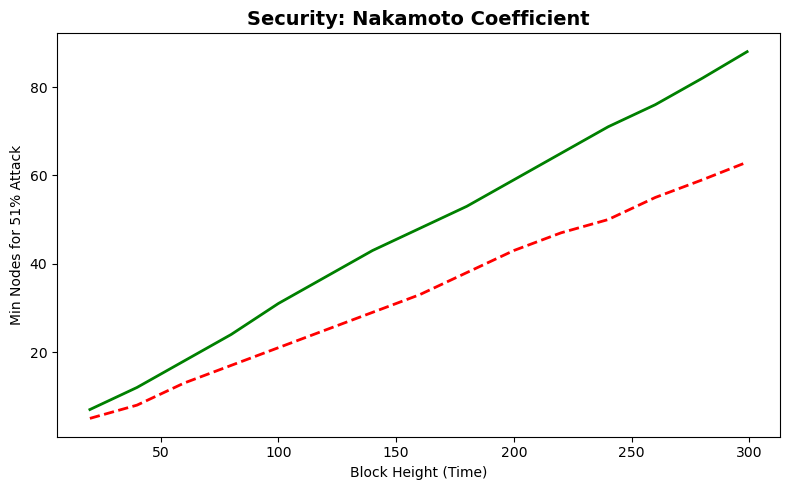

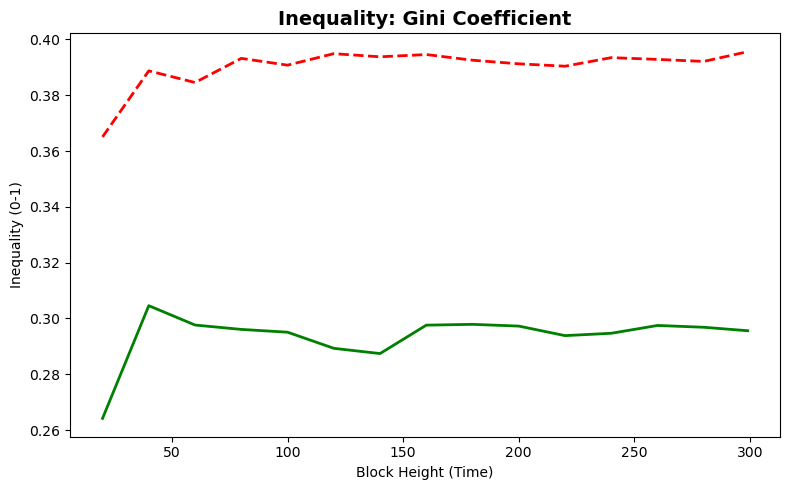

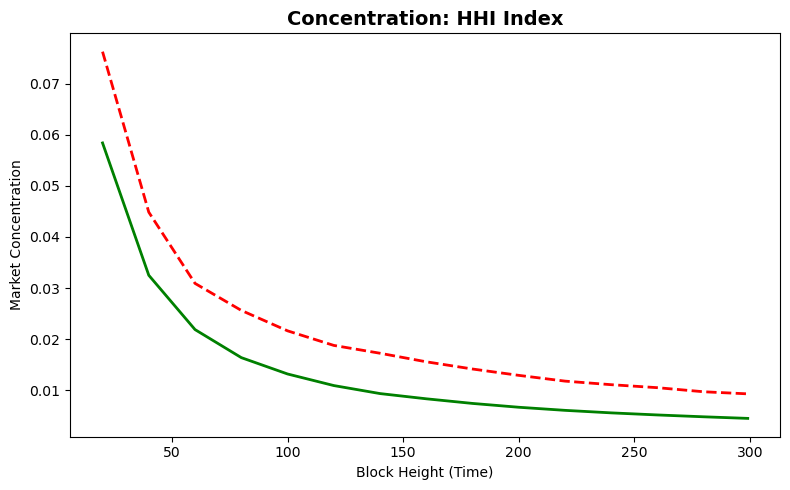

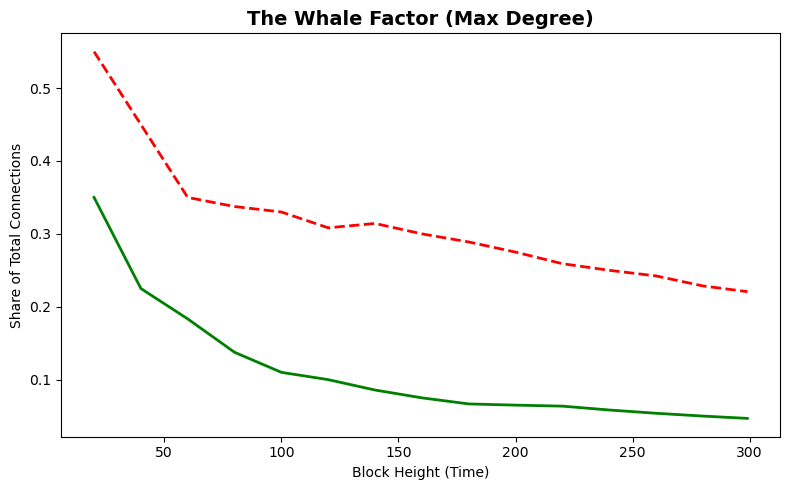

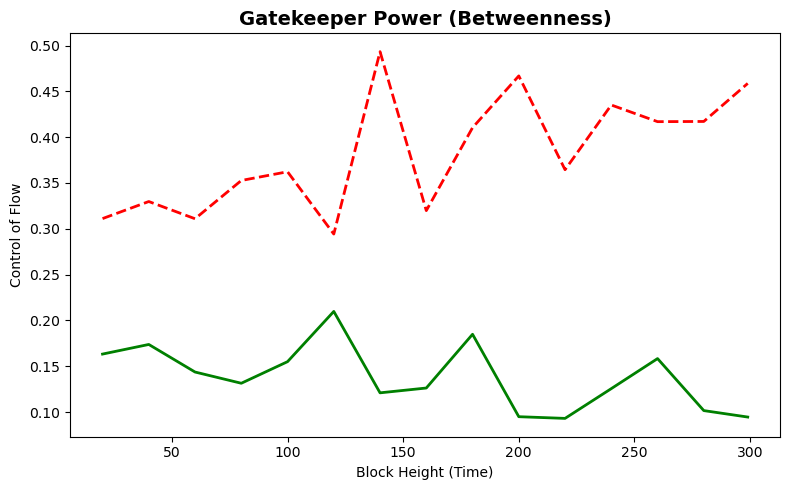

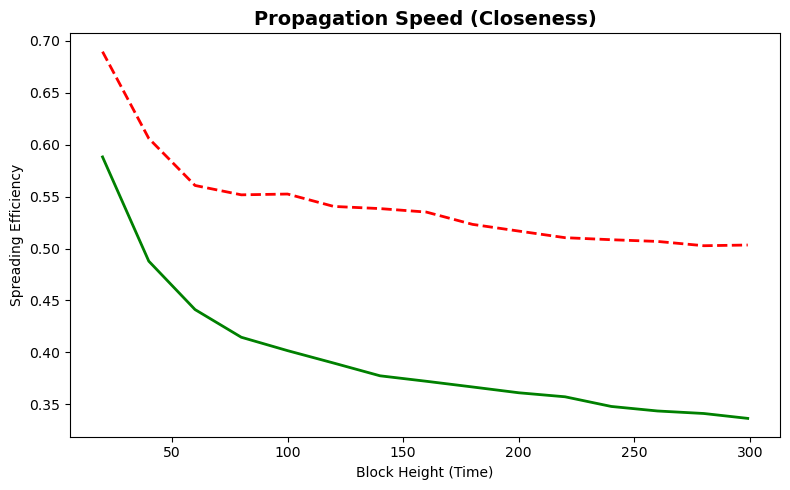

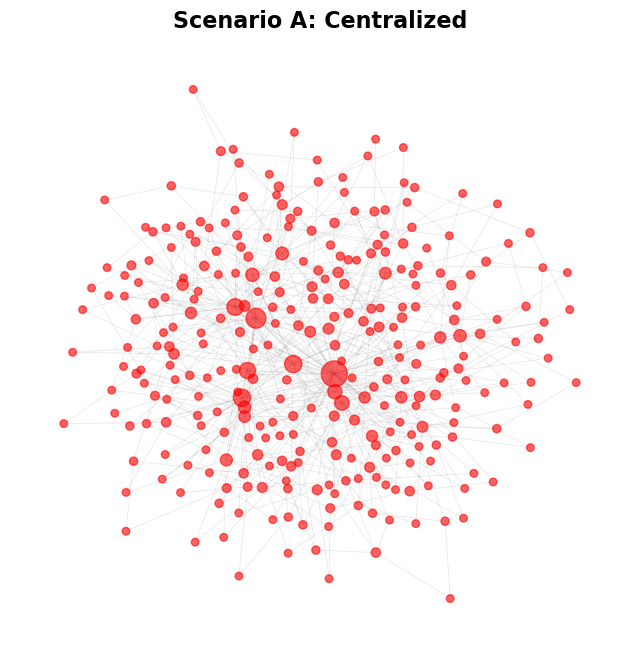

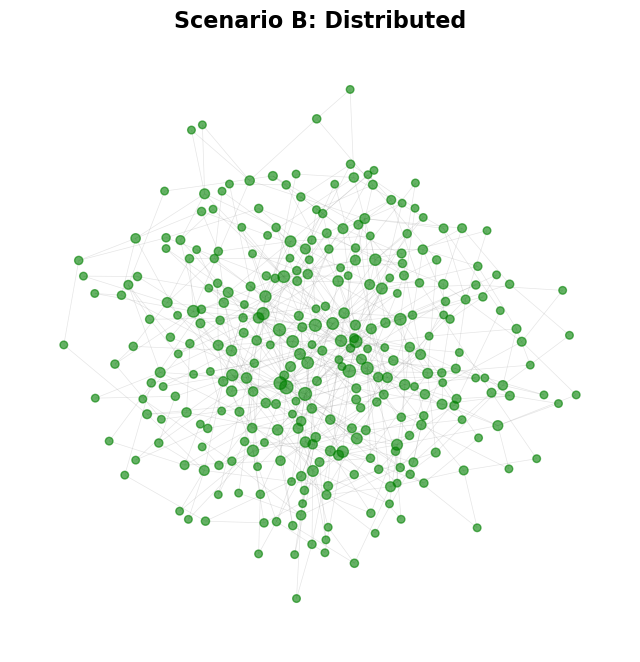

Done! 


In [4]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import random

# ==========================================
# ==========================================
def calculate_metrics(G):
    degrees = np.array([d for n, d in G.degree()])
    if len(degrees) == 0: return 0, 0, 0, 0, 0, 0
    n = len(degrees)
    total_deg = np.sum(degrees)
    
    # Nakamoto
    sorted_deg = np.sort(degrees)[::-1]
    current_sum, nakamoto = 0, 0
    for d in sorted_deg:
        current_sum += d
        nakamoto += 1
        if current_sum > total_deg * 0.51: break
            
    # Gini
    sorted_asc = np.sort(degrees)
    cum_deg = np.cumsum(sorted_asc)
    gini = (n + 1 - 2 * np.sum(cum_deg) / cum_deg[-1]) / n if cum_deg[-1] != 0 else 0
        
    # HHI & Centrality
    shares = degrees / total_deg if total_deg > 0 else degrees
    hhi = np.sum(shares ** 2)
    deg_cent = nx.degree_centrality(G)
    max_deg_c = max(deg_cent.values()) if deg_cent else 0
    k_sample = int(n * 0.1) if n > 100 else None 
    bet_cent = nx.betweenness_centrality(G, k=k_sample) 
    max_bet_c = max(bet_cent.values()) if bet_cent else 0
    clo_cent = nx.closeness_centrality(G)
    max_clo_c = max(clo_cent.values()) if clo_cent else 0
    
    return nakamoto, gini, hhi, max_deg_c, max_bet_c, max_clo_c

# ==========================================
# ==========================================
final_size = 300  
m_edges = 2       
G_centralized = nx.complete_graph(5)
G_decentralized = nx.complete_graph(5)

history = {
    'time': [],
    'A_nakamoto': [], 'A_gini': [], 'A_hhi': [],
    'B_nakamoto': [], 'B_gini': [], 'B_hhi': [],
    'A_deg_c': [], 'A_bet_c': [], 'A_clo_c': [],
    'B_deg_c': [], 'B_bet_c': [], 'B_clo_c': []
}

print("Running simulation...")
for t in range(5, final_size):
    degs_A = [d for n, d in G_centralized.degree()]
    probs_A = np.array(degs_A) / sum(degs_A)
    targets_A = np.random.choice(G_centralized.nodes(), size=m_edges, p=probs_A, replace=False)
    new_A = max(G_centralized.nodes()) + 1
    G_centralized.add_node(new_A)
    for target in targets_A: G_centralized.add_edge(new_A, target)

    targets_B = random.sample(list(G_decentralized.nodes()), m_edges)
    new_B = max(G_decentralized.nodes()) + 1
    G_decentralized.add_node(new_B)
    for target in targets_B: G_decentralized.add_edge(new_B, target)
        
    if t % 20 == 0 or t == final_size - 1:
        res_A = calculate_metrics(G_centralized)
        res_B = calculate_metrics(G_decentralized)
        history['time'].append(t)
        for i, key in enumerate(['nakamoto', 'gini', 'hhi', 'deg_c', 'bet_c', 'clo_c']):
            history[f'A_{key}'].append(res_A[i])
            history[f'B_{key}'].append(res_B[i])

# ==========================================
# ==========================================
def save_plot_clean(filename, title, key_name, ylabel):
    plt.figure(figsize=(8, 5))
    # 强制透明设置
    plt.gcf().patch.set_alpha(0)
    plt.gca().patch.set_alpha(0)
    
    # 删除了 label 参数
    plt.plot(history['time'], history[f'A_{key_name}'], 'r--', linewidth=2)
    plt.plot(history['time'], history[f'B_{key_name}'], 'g-', linewidth=2)
    
    plt.title(title, fontsize=14, fontweight='bold')
    plt.ylabel(ylabel)
    plt.xlabel("Block Height (Time)")
    
    # 去掉网格
    plt.grid(False) 
    
    # 删除了 plt.legend()
    
    plt.tight_layout()
    # 保存透明背景
    plt.savefig(filename, dpi=300, transparent=True)
    plt.show()

# 生成线图
metrics_info = [
    ('1_Nakamoto.png', 'Security: Nakamoto Coefficient', 'nakamoto', 'Min Nodes for 51% Attack'),
    ('2_Gini.png', 'Inequality: Gini Coefficient', 'gini', 'Inequality (0-1)'),
    ('3_HHI.png', 'Concentration: HHI Index', 'hhi', 'Market Concentration'),
    ('4_Max_Degree.png', 'The Whale Factor (Max Degree)', 'deg_c', 'Share of Total Connections'),
    ('5_Betweenness.png', 'Gatekeeper Power (Betweenness)', 'bet_c', 'Control of Flow'),
    ('6_Closeness.png', 'Propagation Speed (Closeness)', 'clo_c', 'Spreading Efficiency')
]

for info in metrics_info:
    save_plot_clean(*info)

# --- 7 & 8. 拓扑图保存 (去标签、透明) ---
def save_topology_clean(G, filename, title, color):
    plt.figure(figsize=(8, 8))
    plt.gcf().patch.set_alpha(0)
    degrees = dict(G.degree())
    pos = nx.spring_layout(G, seed=42, k=0.15)
    
    nx.draw_networkx_nodes(G, pos, node_size=[v*5+20 for v in degrees.values()], node_color=color, alpha=0.6)
    nx.draw_networkx_edges(G, pos, edge_color='gray', alpha=0.2, width=0.5)
    
    plt.title(title, fontsize=16, fontweight='bold')
    plt.axis('off')
    plt.savefig(filename, dpi=300, transparent=True)
    plt.show()

save_topology_clean(G_centralized, '7_Topology_Centralized.png', "Scenario A: Centralized", 'red')
save_topology_clean(G_decentralized, '8_Topology_Distributed.png', "Scenario B: Distributed", 'green')

print("Done! ")